# Correct Application of Nonlinear Buckling Method to Unreinforced Box Beam

## Problem definition

***

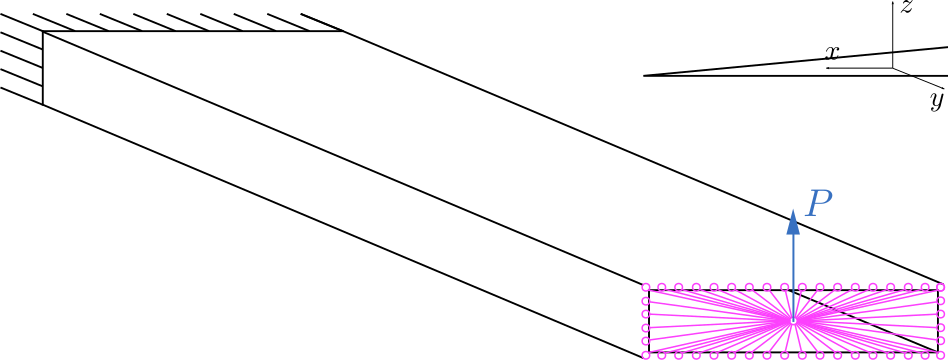

In [1]:
from IPython.display import SVG  # class to embed an SVG into the display
import os  # module with miscellaneous operating system interfaces

SVG(filename=os.path.join('resources', '04_BoxBeamConcentratedLoad.svg'))

In [2]:
AR = 9.   # aspect ratio - 2*b/w (the span of the box beam corresponds to half the span of the CRM wing)
w = 1e3   # width [mm]
b = AR*w/2  # span [mm]
non_dimensional_height = 0.2  # h/w
h = w*non_dimensional_height  # box height [mm]
non_dimensional_thickness = 1/50  # t/h
t = h*non_dimensional_thickness   # shell thickness [mm]
print(f'Box beam dimensions:\n- width: {w/1e3:.1f} m\n- span: {b/1e3:.1f} m\n- height: {h/1e3:.1f} m\n- wall thickness: {t:.1f} mm')

Box beam dimensions:
- width: 1.0 m
- span: 4.5 m
- height: 0.2 m
- wall thickness: 4.0 mm


In [3]:
rho = 2780e-12 # density [ton/mm^3]
E = 73.1e3 # Young's modulus [MPa]
nu = 0.3 # Poisson's ratio

## Setup of the numerical model <a name="numerical-model"></a>

***

### Mesh and boundary conditions

In [4]:
from resources import box_beam_utils

edge_length = 86  # [mm]
nodes_coordinates_array, nodes_connectivity_matrix = box_beam_utils.mesh_box(width=w, span=b, height=h, edge_length=edge_length)

In [5]:
box_beam_bdf_input = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t, nodes_xyz_array=nodes_coordinates_array, nodes_connectivity_matrix=nodes_connectivity_matrix)
print(box_beam_bdf_input.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.spcs[1]: 1
  SPC1:    1

bdf.params: 0
  PARAM    : 1

bdf.nodes: 0
  GRID     : 1760

bdf.elements: 0
  CQUAD4   : 1728

bdf.properties: 0
  PSHELL   : 1

bdf.materials: 0
  MAT1     : 1




subcase=0 already exists...skipping


### Load

In [6]:
import numpy as np

# Add master node of tip section
master_node_id = np.size(nodes_coordinates_array, 0) + 1
box_beam_bdf_input.add_grid(master_node_id, [w/2, b, 0.])

# Add RBE2 element to make tip section rigid
nodes_ids = np.arange(1, np.size(nodes_coordinates_array, 0) + 1)
tip_nodes_ids = nodes_ids[nodes_coordinates_array[:,1]==b]
rbe2_eid = len(box_beam_bdf_input.elements) + 1
box_beam_bdf_input.add_rbe2(rbe2_eid, master_node_id, '123456', tip_nodes_ids)

# Add concentrated force
force_set_id = 11
concentrated_force_magnitude = 1.
concentrated_force_direction = [0., 0., 1.]
box_beam_bdf_input.add_force(sid=force_set_id, node=master_node_id, mag=concentrated_force_magnitude, xyz=concentrated_force_direction)

FORCE         11    1761              1.      0.      0.      1.

## Correct application of nonlinear buckling method

***

In [7]:
from resources import pynastran_utils
from pyNastran.op2.op2 import read_op2

# Define name of analysis directory
analysis_directory_name = '14_Correct_Application_of_Nonlinear_Buckling_Method_to_Unreinforced_Box_Beam'
analysis_directory_path = os.path.join(os.getcwd(), 'analyses', analysis_directory_name)

# Function to set up the nonlinear analysis with the nonlinear buckling methods for increasing applied loads
def run_nonlinear_buckling_method_sweep(bdf_input, load_magnitudes, input_filename, run_flag=True):
    # Set up nonlinear analysis with arc-length method
    pynastran_utils.set_up_arc_length_method(bdf_object=bdf_input, ninc=100, max_iter=25, conv='PW', eps_p=1e-3, eps_w=1e-7, max_bisect=10, minalr=.01, maxalr=1.1, desiter=5, maxinc=1000)
    # Create the LOAD cards corresponding to the input load magnitudes and the associated subcases
    for i, scale_factor in enumerate(load_magnitudes):
        load_set_id = 21+i
        bdf_input.add_load(sid=load_set_id, scale=1., scale_factors=[scale_factor], load_ids=[force_set_id])
        pynastran_utils.create_static_load_subcase(bdf_object=bdf_input, subcase_id=i+1, load_set_id=load_set_id)
    # Run SOL 106 with nonlinear buckling method
    pynastran_utils.run_sol_106_buckling_analysis(bdf_input, force_set_id+1, analysis_directory_path, input_filename, run_flag=True)
    # Read op2 file
    op2_filepath = os.path.join(analysis_directory_path, input_filename + '.op2')
    op2 = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)
    # Return op2 object
    return op2

In [8]:
linear_buckling_load = 1657   # [N]
applied_load_magnitudes = np.linspace(0, 2*linear_buckling_load, 11)[1:]
np.set_printoptions(precision=0, suppress=True)
print(f'Applied loads [N]: {applied_load_magnitudes}')

Applied loads [N]: [ 331.  663.  994. 1326. 1657. 1988. 2320. 2651. 2983. 3314.]


In [9]:
# Run analysis
input_name = 'nonlinear_buckling_method'
op2_output = run_nonlinear_buckling_method_sweep(box_beam_bdf_input.__deepcopy__({}), applied_load_magnitudes, input_name, run_flag=True)

Nastran job nonlinear_buckling_method.bdf completed
Wall time: 269.0 s


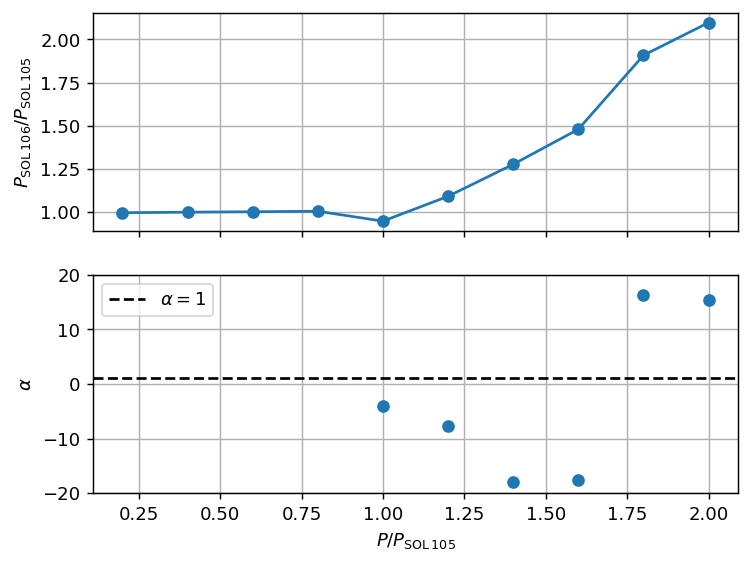

In [11]:
import matplotlib.pyplot as plt

# Function to plot SOL 106 buckling loads and critical buckling factors against applied loads
def plot_buckling_loads(applied_loads, sol_105_buckling_load, sol_106_buckling_loads, alphas):
    _, axs = plt.subplots(nrows=2, ncols=1, sharex='all')  # figure with 2 subplots
    axs[0].plot(applied_loads/sol_105_buckling_load, sol_106_buckling_loads/sol_105_buckling_load, '-o')  # buckling loads vs applied loads
    axs[1].plot(applied_loads/sol_105_buckling_load, alphas, 'o')  # critical buckling factors vs applied loads
    axs[1].axhline(y=1, color='k', ls='--', label='$\\alpha=1$')  # alpha=1 reference line
    # Set plot appearance
    axs[0].set_ylabel('$P_\mathrm{SOL\/106}/P_\mathrm{SOL\/105}$')
    axs[0].grid(visible=True)
    axs[1].set_ylabel('$\\alpha$')
    axs[1].grid(visible=True)
    axs[1].legend()
    axs[1].set_xlabel('$P/P_\mathrm{SOL\/105}$')
    axs[1].set_ylim([-20, 20])
    plt.show()

# Set default dpi of figures
plt.rcParams['figure.dpi'] = 130

# Find nonlinear buckling loads and critical buckling factors
nonlinear_buckling_loads, critical_buckling_factors = pynastran_utils.read_nonlinear_buckling_load_from_f06(f06_filepath=os.path.join(analysis_directory_path, input_name + '.f06'), op2_object=op2_output)

# Plot results
plot_buckling_loads(applied_load_magnitudes, linear_buckling_load, nonlinear_buckling_loads, critical_buckling_factors)